<a href="https://colab.research.google.com/github/simulate111/Computer-Vision-and-Sensor-Fusion/blob/main/assignment_2_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Add libraries

In [1]:
import tensorflow as tf
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet50
import os
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import zipfile
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

### Path system

In [2]:
# you need the current working directory NB: works both windows and linux
current_working_directory = os.getcwd()
current_working_directory = os.path.dirname(current_working_directory)

# get the directory where I want to download the dataset
path_of_download = os.path.join(*['..', current_working_directory, 'Datasets', 'weather_dataset'])
print(f"[DIR] The directory of the current dataset is {path_of_download}")

[DIR] The directory of the current dataset is /Datasets/weather_dataset


### function for data loading

In [3]:
# here let s do some functions that we can re-use also for other assignment
def load_the_data_and_the_labels(data_set_path: str, target_size: tuple or None = None):
    try:
        dataset, labels, name_of_the_labels = list(), list(), list()
        # let s loop here and we try to discover how many class we have
        for class_number, class_name in enumerate(os.listdir(data_set_path)):
            full_path_the_data = os.path.join(data_set_path, class_name)
            print(f"[WALK] I am walking into {full_path_the_data}")

            # add the list to nam _list
            name_of_the_labels.append(class_name)

            for single_image in os.listdir(f"{full_path_the_data}"):
                full_path_to_image = os.path.join(*[full_path_the_data, single_image])

                # add the class number
                labels.append(class_number)

                if target_size is None:
                    # let s load the image
                    image = tf.keras.utils.load_img(full_path_to_image)
                else:
                    image = tf.keras.utils.load_img(full_path_to_image, target_size=target_size)

                # transform PIL object in image
                image = tf.keras.utils.img_to_array(image)

                # add the image to the ds list
                dataset.append(image)

        return np.array(dataset, dtype='uint8'), np.array(labels, dtype='int'), name_of_the_labels
    except Exception as ex:
        print(f"[EXCEPTION] load the data and the labels throws exceptions {ex}")

### OHE function

In [4]:
# here we have to one hot encode the labes
def make_the_one_hot_encoding(labels_to_transform):
    try:
        enc = OneHotEncoder(handle_unknown='ignore')
        # this is a trick to figure the array as 2d array instead of list
        temp = np.reshape(labels_to_transform, (-1, 1))
        labels_to_transform = enc.fit_transform(temp).toarray()
        print(f'[ONE HOT ENCODING] Labels are one-hot-encoded: {(labels_to_transform.sum(axis=1) - np.ones(labels_to_transform.shape[0])).sum() == 0}')
        return labels_to_transform
    except Exception as ex:
        print(f"[EXCEPTION] Make the one hot encoding throws exception {ex}")

### load the data and labels

In [5]:
from google.colab import files
#uploaded = files.upload()

In [6]:
url = "https://seafile.utu.fi/f/88c08f841e0348e1a412/?dl=1"
zip_path = "/content/weather_dataset.zip"
urllib.request.urlretrieve(url, zip_path)

('/content/weather_dataset.zip', <http.client.HTTPMessage at 0x7bb49e7936d0>)

In [7]:
extract_path = "/content/weather_dataset"
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

In [8]:
dataset, labels, class_names = load_the_data_and_the_labels("/content/weather_dataset/weather_dataset", target_size=(224, 224))

[WALK] I am walking into /content/weather_dataset/weather_dataset/Sunrise
[WALK] I am walking into /content/weather_dataset/weather_dataset/Rain
[WALK] I am walking into /content/weather_dataset/weather_dataset/Shine
[WALK] I am walking into /content/weather_dataset/weather_dataset/Cloudy


### normalize the data

In [9]:
# Normalize images
dataset = dataset / 255.0

In [10]:
encoded_labels = make_the_one_hot_encoding(labels)

[ONE HOT ENCODING] Labels are one-hot-encoded: True


### split the dataset in train and test set (ratio 0.3)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(dataset, encoded_labels, test_size=0.3, stratify=labels)

### create the CNN and set all parameters to trainable
a.	Input layer
b.	As base model use VGG19:
    i.	Weights: imagenet
    ii.	Include_top: False
    iii.	Input_shape the target shape described in point 1.
c.	Add a flatten layer
d.	Add a Dense layer with 512 units and a dropout layer with 0.1 unit.
e.	Add a Dense layer with 256 units and a dropout layer with 0.1 unit.
f.	Add the final classifier with the correct number of units and the suitable activation.


In [12]:
def cnn_ResNet50(input_shape=(224, 224, 3), num_classes=4):
    #a
    input_layer = Input(shape=input_shape)
    #b
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_layer)
    base_model.trainable = True
    #c
    flatten_layer = Flatten()(base_model.output)
    #d
    dense = Dense(512, activation='relu')(flatten_layer)
    dropout = Dropout(0.1)(dense)
    #e
    dense2 = Dense(256, activation='relu')(dropout)
    dropout2 = Dropout(0.1)(dense2)
    #f
    output_layer = Dense(num_classes, activation='softmax')(dropout2)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [13]:
model = cnn_ResNet50()
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 75,100,804 (286.49 MB)

 Trainable params: 75,047,684 (286.28 MB)

 Non-trainable params: 53,120 (207.50 KB)

### compile the model with adam

In [14]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

### Fit the model with batch size 32 and 15 epochs (This take 15 - 20 minutes with the CPU)

In [15]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=15)

Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.6139 - loss: 1.4826 - val_accuracy: 0.3195 - val_loss: 1.5678
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 336ms/step - accuracy: 0.9837 - loss: 0.0606 - val_accuracy: 0.3166 - val_loss: 2.1224
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 337ms/step - accuracy: 0.9904 - loss: 0.0163 - val_accuracy: 0.3166 - val_loss: 2.8294
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 338ms/step - accuracy: 0.9993 - loss: 0.0027 - val_accuracy: 0.3166 - val_loss: 3.3063
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 339ms/step - accuracy: 0.9981 - loss: 0.0027 - val_accuracy: 0.3166 - val_loss: 4.9526
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 328ms/step - accuracy: 0.9979 - loss: 0.0047 - val_accuracy: 0.3166 - val_loss: 4.3298
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 332ms/step - accuracy: 1.0000 - loss: 5.3072e-05 - val_accuracy: 0.3166 - val_loss: 4.5640
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.9981 - loss: 0.0031 - val_acc

### Evaluate  the model

In [16]:
model.evaluate(X_test, y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.2401 - loss: 3.7142


[3.7269082069396973, 0.22781065106391907]

#### Make and show predictions

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 437ms/step


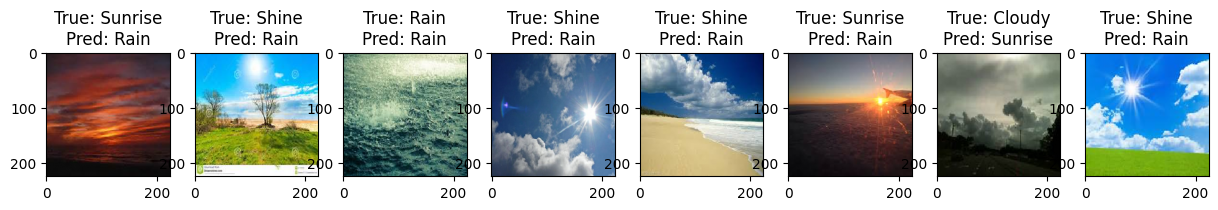

In [17]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
def plot_predictions(images, true_labels, predicted_labels, class_names, num_images=8):
    plt.figure(figsize=(15, 7))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        true_label = class_names[true_labels[i]]
        predicted_label = class_names[predicted_labels[i]]
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
plot_predictions(X_test, true_classes, predicted_classes, class_names)

### make confusion matrix

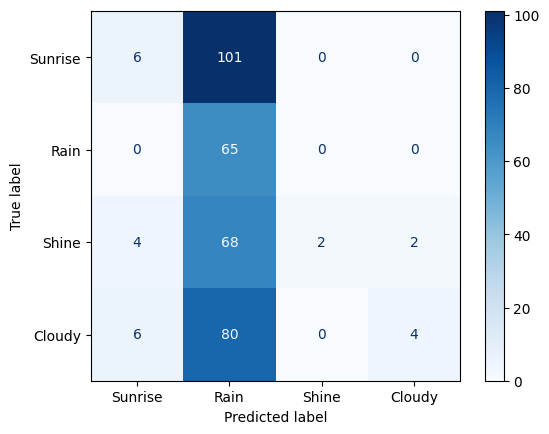

In [18]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

### Load again the cnn but this time set the parameters to NOT TRAINABLE

In [19]:
def cnn_ResNet50_non_trainable(input_shape=(224, 224, 3), num_classes=4):
    input_layer = Input(shape=input_shape)
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_layer)
    base_model.trainable = False
    flatten_layer = Flatten()(base_model.output)
    dense = Dense(512, activation='relu')(flatten_layer)
    dropout = Dropout(0.1)(dense)
    dense2 = Dense(256, activation='relu')(dropout)
    dropout2 = Dropout(0.1)(dense2)
    output_layer = Dense(num_classes, activation='softmax')(dropout2)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

### Fit the model with batch size 32 and 15 epochs (This is fsaster)

In [20]:
model2 = cnn_ResNet50_non_trainable()
model2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model2.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=15)

Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 521ms/step - accuracy: 0.2667 - loss: 1.9398 - val_accuracy: 0.3254 - val_loss: 1.3265
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.3283 - loss: 1.4312 - val_accuracy: 0.3195 - val_loss: 1.3010
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.3570 - loss: 1.3398 - val_accuracy: 0.4527 - val_loss: 1.2595
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.3896 - loss: 1.2701 - val_accuracy: 0.4408 - val_loss: 1.2022
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.4423 - loss: 1.2372 - val_accuracy: 0.5385 - val_loss: 1.2076
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.4724 - loss: 1.2151 - val_accuracy: 0.4408 - val_loss: 1.1973
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.4378 - loss: 1.2225 - val_accuracy: 0.3254 - val_loss: 1.2615
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.4474 - loss: 1.1797 - val_accuracy: 0

# Evaluate the model

In [21]:
test_loss, test_accuracy = model2.evaluate(X_test, y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.4206 - loss: 1.0404


### Make and show some predictions

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 419ms/step


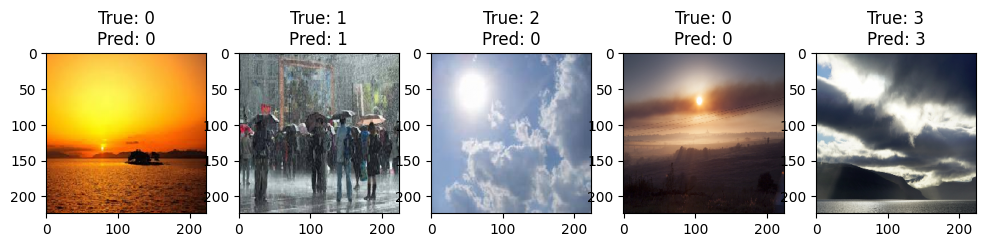

In [22]:
y_pred = model2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
num_samples = 5
random_indices = np.random.choice(len(X_test), num_samples, replace=False)
plt.figure(figsize=(12, 6))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(X_test[idx])
    true_label = y_true_classes[idx]
    pred_label = y_pred_classes[idx]
    plt.title(f"True: {true_label}\nPred: {pred_label}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


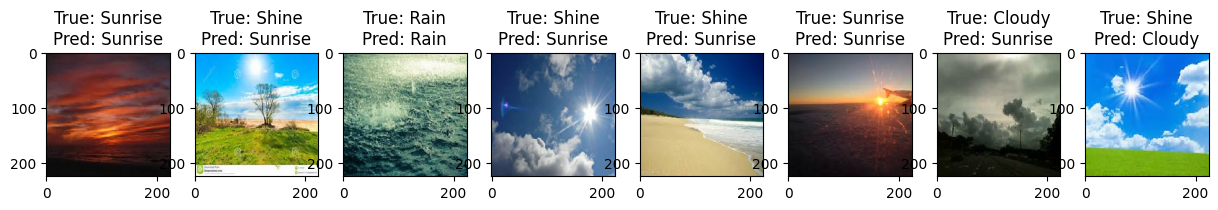

In [23]:
predictions = model2.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
def plot_predictions(images, true_labels, predicted_labels, class_names, num_images=8):
    plt.figure(figsize=(15, 7))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        true_label = class_names[true_labels[i]]
        predicted_label = class_names[predicted_labels[i]]
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
plot_predictions(X_test, true_classes, predicted_classes, class_names)

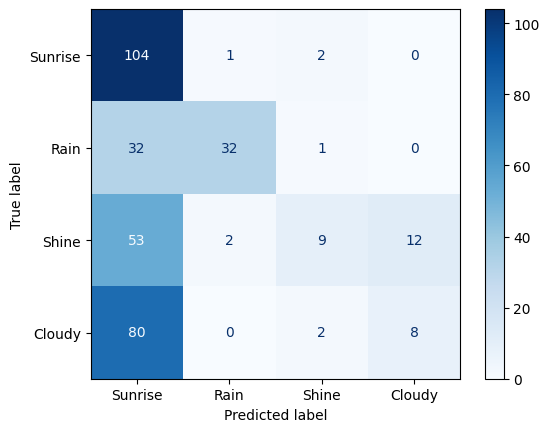

In [24]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)